In [1]:
from torch.autograd import Variable
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.layer2=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3),nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.layer3=nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer4=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )


        self.fc=nn.Sequential(
            nn.Linear(128*4*4,256),
            nn.ReLU(inplace=True),
            nn.Linear(256,10) )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)
        x = x.view(x.size(0),-1)
        x=self.fc(x)
        return x

In [3]:
batch_size=64
learning_rate=1e-2
num_epoches=20
data_tf = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    )
train_dataset=datasets.MNIST(root='./data',train=True,transform=data_tf,
                             download=True)
test_dataset=datasets.MNIST(root='./data',train=False,transform=data_tf)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [4]:
model=torch.load('model.pkl')

D:\Anaconda\lib\site-packages\torch\serialization.py:391: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [5]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

In [6]:
def test():
    # model.eval()
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        img, label = data
        # img = img.view(img.size(0), -1)
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
        # out = model(img)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.data.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(
        eval_loss / (len(test_dataset)),
        eval_acc / (len(test_dataset))
    ))



In [7]:
test()

Test Loss: 0.024751, Acc: 0.992300


In [8]:
def make_noise(input_data,aimtarget,epoch):
    noise=torch.rand(1,1,28,28).float().cuda()
    data=(1/255)*input_data.float().reshape(1,1,28,28).cuda()
    target=torch.tensor(aimtarget).unsqueeze(0).long().cuda()
    noise.requires_grad=True
    advoptimizer=optim.SGD([noise],lr=learning_rate)
    for i in range(epoch):
        img=data+noise
        ans=model(img)
        loss=criterion(ans,target)+noise.norm()**(1.8)
        advoptimizer.zero_grad()
        loss.backward()
        advoptimizer.step()
    return noise
    

tensor(5.3778, device='cuda:0', grad_fn=<NormBackward0>)
aimtarget:5
result target:5


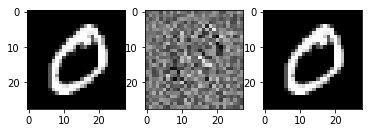

In [9]:
data1=train_dataset.train_data[1]
noise_1=make_noise(data1,5,100)
ans=model(noise_1+(1/255)*data1.float().reshape(1,1,28,28).cuda())
# print('the norm of noise_1 is{}'.format(noise_1.norm())
print(noise_1.norm())
print('aimtarget:{}'.format(5))
print('result target:{}'.format(torch.max(ans,1)[1].item()))
plt.subplot(131)
plt.imshow(data1.reshape(28,28),cmap='gray')
plt.subplot(132)
plt.imshow(noise_1.cpu().detach().numpy().reshape(28,28),cmap='gray')
plt.subplot(133)
plt.imshow(noise_1.cpu().detach().numpy().reshape(28,28)+data1.reshape(28,28),cmap='gray')

In [11]:
totalnorm=0
acc=0
for i in range(1000):
    data=train_dataset.train_data[i]
    noise=make_noise(data,7,300)
    ans=model(noise+(1/255)*data.float().reshape(1,1,28,28).cuda())
    if torch.max(ans,1)[1].item()==7:
        acc+=1
        totalnorm+=noise.norm()
print(totalnorm/200)
print(acc/200)

tensor(6.7815, device='cuda:0', grad_fn=<DivBackward0>)
5.0


In [12]:
print(totalnorm/1000)
print(acc/1000)

tensor(1.3563, device='cuda:0', grad_fn=<DivBackward0>)
1.0
